In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import cluster, pairwise_distances
from sklearn.manifold import TSNE

from tqdm import tqdm

from FlagRep import FlagRep, chordal_distance


In [6]:
def set_seed(seed):
    # Set the seed for random number generation
    np.random.seed(seed)                   # NumPy random seed
    torch.manual_seed(seed)                # PyTorch random seed
    torch.cuda.manual_seed(seed)           # If using GPU
    torch.cuda.manual_seed_all(seed)       # For all GPUs
    torch.backends.cudnn.deterministic = True  # Make cuDNN deterministic
    torch.backends.cudnn.benchmark = False  # Disable auto-tuner for reproducibility

# Example usage
set_seed(42)


In [7]:


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs


# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        # Input layer to hidden layer 1
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Hidden layer 1 to hidden layer 2
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 2 to hidden layer 3
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 3 to output layer (10 classes)
        self.fc4 = nn.Linear(hidden_size, output_size)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the output (for logits)
        return x

In [8]:

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


# Set up hyperparameters
input_size = 28 * 28  # Flattened image size
hidden_size = 128     # Same size for all hidden layers
output_size = 10      # 10 output classes (digits 0-9)
num_epochs = 10
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Flatten the images from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        images = images.view(-1, 28*28)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  # Flatten images
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 0.1146
Epoch [2/10], Loss: 0.1311
Epoch [3/10], Loss: 0.1217
Epoch [4/10], Loss: 0.1148
Epoch [5/10], Loss: 0.2003
Epoch [6/10], Loss: 0.0118
Epoch [7/10], Loss: 0.0034
Epoch [8/10], Loss: 0.0172
Epoch [9/10], Loss: 0.0531
Epoch [10/10], Loss: 0.0046
Test Accuracy: 97.56%


In [9]:
torch.save(model.state_dict(), '../models/mnist_model.pth')


In [19]:
# Set up hyperparameters
input_size = 28 * 28  # Flattened image size
hidden_size = 128     # Same size for all hidden layers
output_size = 10      # 10 output classes (digits 0-9)
num_epochs = 10
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('../models/mnist_model.pth'))


<All keys matched successfully>

In [20]:

# Pass the sample through the network step-by-step without computing gradients
# train_mats = []
# for img,_ in train_dataset:
#     sample_image = img.view(-1, 28*28)
#     with torch.no_grad():
#         # Step-by-step pass through each layer
#         h10 = model.fc1(sample_image)
#         h11 = model.relu(h10)  # Pass through first hidden layer
#         h20 = model.fc2(h11)
#         h21 = model.relu(h20)         # Pass through second hidden layer
#         h30 = model.fc3(h21)
#         h31 = model.relu(h30)         # Pass through third hidden layer

#         hidden_rep = [h.cpu().detach().numpy().T for h in [h10,h11,h20,h21,h30,h31]]
#     train_mats.append(np.hstack(hidden_rep))

# Pass the sample through the network step-by-step without computing gradients
test_mats = []
for img,_ in test_dataset:
    sample_image = img.view(-1, 28*28)
    with torch.no_grad():
        # Step-by-step pass through each layer
        h10 = model.fc1(sample_image)
        h11 = model.relu(h10)  # Pass through first hidden layer
        h20 = model.fc2(h11)
        h21 = model.relu(h20)  # Pass through second hidden layer
        h30 = model.fc3(h21)
        h31 = model.relu(h30)  # Pass through third hidden layer

        if np.any(h10.cpu().detach().numpy() < 0) or np.any(h20.cpu().detach().numpy()<0) or np.any(h30.cpu().detach().numpy() < 0):
            print('oops')

        hidden_rep = [h.cpu().detach().numpy().T for h in [h10,h11,h20,h21,h30,h31]]
        # hidden_rep = [h.cpu().detach().numpy().T for h in [h20,h21,h30,h31]]
    test_mats.append(np.hstack(hidden_rep))



oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops


In [21]:
As = [np.arange(2),np.arange(4),np.arange(6)]
# As = [np.arange(2),np.arange(4)]
flag_type = [2,4,6]
# flag_type = [2,4]
cutoff = .95

In [22]:

flags = {}
flags['FlagRep'] = []
flags['QR'] = []

flag_types = {}
flag_types['FlagRep'] = []
flag_types['QR'] = []
for m in tqdm(test_mats):
    frep, frep_ftype = FlagRep(m, As, eps_rank = cutoff)
    flags['FlagRep'].append(frep)
    flag_types['FlagRep'].append(frep_ftype)

    qr ,_= np.linalg.qr(m)
    flags['QR'].append(qr)
    flag_types['QR'].append(flag_type)


100%|██████████| 10000/10000 [01:34<00:00, 105.36it/s]


In [23]:
np.unique(flag_types['FlagRep'])

array([2, 4, 6])

In [24]:


n_pts = 1000 #len(flags['FlagRep'])
dist_mats = {}
for method_name in ['FlagRep', 'QR']:
    #make distance matrices
    dist_mats[method_name] = np.zeros((n_pts,n_pts))
    for i in tqdm(range(n_pts)):
        for j in range(i+1,n_pts):
            x = flags[method_name][i]
            y = flags[method_name][j]
            if method_name == 'Euclidean':
                dist = np.linalg.norm(x-y)
            else:
                fl_type_x = flag_types[method_name][i]
                fl_type_y = flag_types[method_name][j]
                Bs_x = make_Bs(fl_type_x)
                Bs_y = make_Bs(fl_type_y)
                dist = chordal_distance(x, y, Bs_x, Bs_y)
            dist_mats[method_name][i,j] = dist
            dist_mats[method_name][j,i] = dist
            

100%|██████████| 1000/1000 [00:58<00:00, 17.07it/s]


In [25]:
mod_labels = [l for _, l in test_dataset][:n_pts]

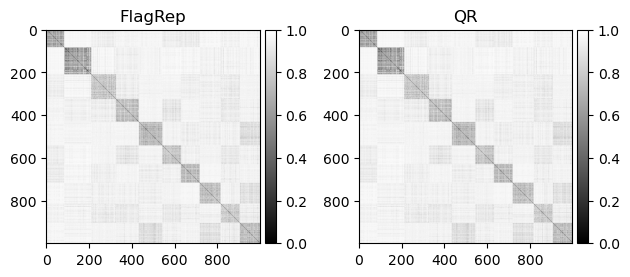

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt

sort_idx = np.argsort(mod_labels)
fig, ax = plt.subplots(1,2)
for i, method_name in enumerate(['FlagRep', 'QR']):
    im = ax[i].imshow(dist_mats[method_name][sort_idx, :][:,sort_idx]/dist_mats[method_name].max(), cmap = 'grey')
    ax[i].set_title(method_name)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()

In [29]:
np.unique(flag_types['FlagRep'])

array([2, 4, 6])

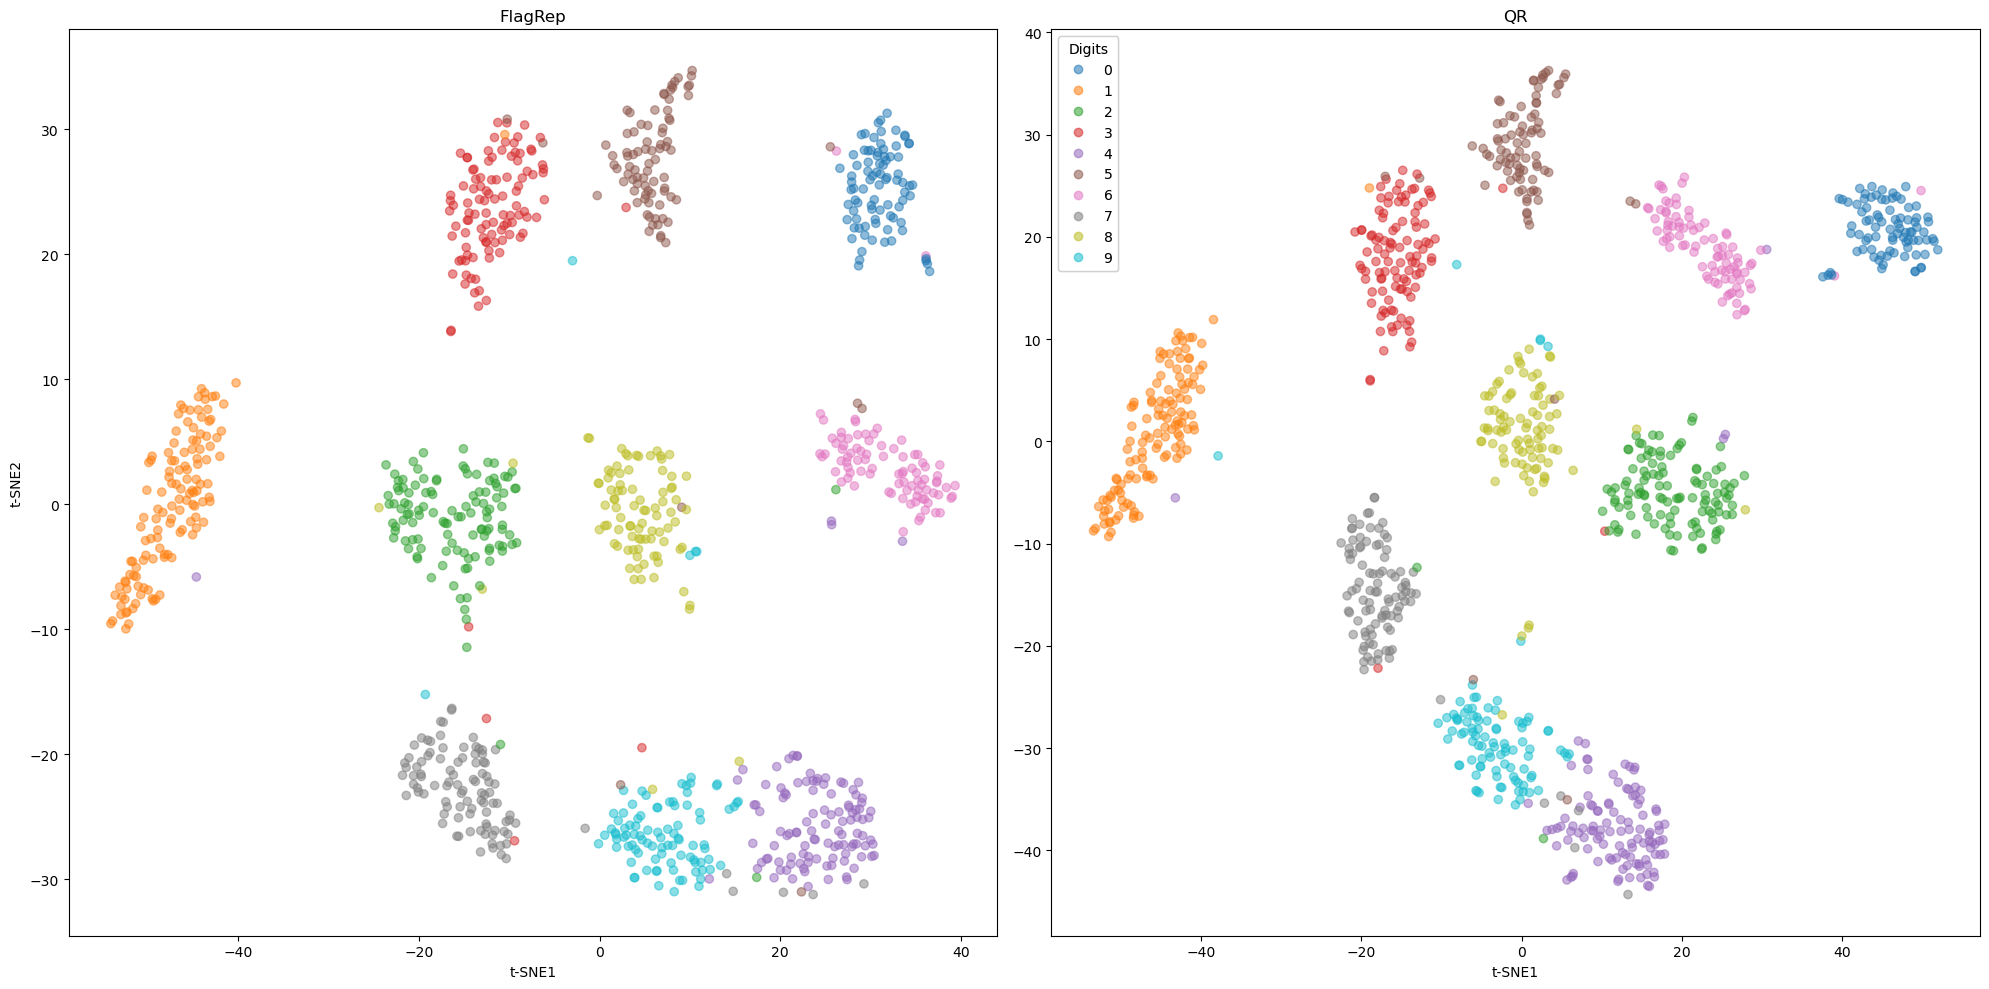

FlagRep: 0.814
QR: 0.88


In [78]:

fig,ax = plt.subplots(1,2, figsize = (20,10))

for i, method_name in enumerate(['FlagRep', 'QR']):
    tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
    vis_data = tsne.fit_transform(dist_mats[method_name])

    scatter = ax[i].scatter(vis_data[:,0], vis_data[:,1], alpha=.5, c=mod_labels, cmap='tab10')
    ax[i].set_xlabel('t-SNE1')
    ax[i].set_title(method_name)
ax[0].set_ylabel('t-SNE2')
# Create a legend with labels
legend = plt.legend(*scatter.legend_elements(), title="Digits")
plt.gca().add_artist(legend)
plt.tight_layout()
plt.show()

for method_name in ['FlagRep', 'QR']:
    n_clusters = 10  # Define the number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
    cluster_labels = clustering.fit_predict(dist_mats[method_name])

    res = purity_score(mod_labels, cluster_labels)

    print(f'{method_name}: {res}')

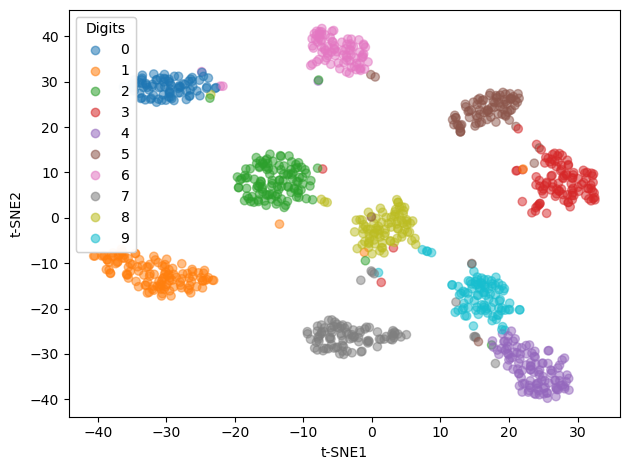

0.572

In [41]:
# Pass the sample through the network step-by-step without computing gradients
test_mats_baseline = []
for img,_ in test_dataset:
    sample_image = img.view(-1, 28*28)
    with torch.no_grad():
        # Step-by-step pass through each layer
        h10 = model.fc1(sample_image)
        h11 = model.relu(h10)  # Pass through first hidden layer
        h20 = model.fc2(h11)
        h21 = model.relu(h20)         # Pass through second hidden layer
        h30 = model.fc3(h21)
        h31 = model.relu(h30)         # Pass through third hidden layer

        hidden_rep = h31.cpu().detach().numpy()
    test_mats_baseline.append(hidden_rep)

small_euc_data = np.vstack(test_mats_baseline)[:n_pts,:]

euc_distances = pairwise_distances(small_euc_data, metric='euclidean')
tsne = TSNE(n_components=2, metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(euc_distances)

scatter = plt.scatter(vis_data[:,0], vis_data[:,1], alpha=.5, c=mod_labels, cmap='tab10')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
# Create a legend with labels
legend = plt.legend(*scatter.legend_elements(), title="Digits")
plt.gca().add_artist(legend)
plt.tight_layout()
plt.show()



n_clusters = 10  # Define the number of clusters
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
cluster_labels = clustering.fit_predict(euc_distances)

purity_score(mod_labels, cluster_labels)
